In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import warnings

from os.path import join
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

datapath = join('data', 'wafer')

warnings.filterwarnings("ignore")

https://www.kaggle.com/code/teeeady/keras-wafer-classification-cnn2d

## Image Data Preprocessing

In [6]:
 # image size drop
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

 # Data preprocessing process
def __Inputdf__(Hei, Wei):
    sub_df = df.loc[df['waferMapDim'] == (Hei, Wei)]
    sw = np.ones((1,  Hei, Wei))
    label = list()

    for i in range(len(sub_df)):
        if len(sub_df.iloc[i, :]['failureType']) == 0:
            continue
        sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, Hei, Wei)))
        label.append(sub_df.iloc[i, :]['failureType'][0][0])
    
    x = sw[1:]
    y = np.array(label).reshape((-1,1))
    
    #add channel
    x = x.reshape((-1, Hei, Wei, 1))
    new_x = np.zeros((len(x), Hei, Wei, 3))

    for w in range(len(x)):
        for i in range(Hei):
            for j in range(Wei):
                new_x[w, i, j, int(x[w, i, j])] = 1
    return new_x, y

 # Two ways to Scaling
def __InputTf1__(new_x):
    new_result = tf.compat.v1.image.resize(new_x, (26,26),
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
                                       align_corners=True,
                                       preserve_aspect_ratio=False, 
                                       name=None)
    return new_result
def __InputTf2__(new_x):
    new_result = tf.keras.preprocessing.image.smart_resize(new_x, 
                                                           (26,26),
                                                           interpolation = 'nearest')
    return new_result

# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

 # Saving and loading new_x and new_y variables
def save_new_x(new_x):
    f = open("./save_new_x.csv", "w")
    for w in range(len(new_x)):
        for i in range(26):
            for j in range(26):
                for o in range(3):
                    f.write(str(new_x[w][i][j][o]))
                
    f.close()
    return 

 """ 
 Save it as a csv file and 
 take it out again to 
 learn because of the lack of 
 maximum memory inside Kaggle. 
 """ 

' \nSave it as a csv file and \ntake it out again to \nlearn because of the lack of \nmaximum memory inside Kaggle. \n'

### Read data

In [7]:
df=pd.read_pickle('D:\AI in EDA\LSWMD(Kaggle)\LSWMD.pkl')

- The dataset comprises 811,457 wafer maps, along with additional information such as wafer die size, lot name and wafer index.

- The training / test set were already split by domain experts, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

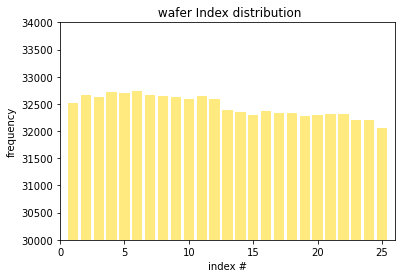

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

- The figure shows that not all lots have perfect 25 wafer maps and it may caused by sensor failure or other unknown problems.

- Fortunately, we do not need wafer index feature in our classification so we can just drop the variable.

In [9]:
df = df.drop(['waferIndex'], axis = 1)

- We can not get much information from the wafer map column but we can see the die size for each instance is different.

- We create a new variable 'waferMapDim' for wafer map dim checking.

In [10]:
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
235643,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2598.0,lot14736,[],[],"(57, 57)"
376692,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",811.0,lot22457,[],[],"(34, 31)"
191998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1746.0,lot12156,[],[],"(47, 47)"
765581,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1791.0,lot45676,[[Training]],[[none]],"(48, 48)"
285797,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4096.0,lot17446,[],[],"(72, 72)"


## Image Data Preprocessing

### Get sub wafer with resolution.
Wafer is resized to have (26, 26) resolution. rearrange wafer nd-array with faulty case label.
some wafer has null label, skip it. 
First, let's create two types of resolution data by combining them.

In [ ]:
 # Data preprocessing process
def __Inputdf__(Hei, Wei):
    sub_df = df.loc[df['waferMapDim'] == (Hei, Wei)]
    sw = np.ones((1,  Hei, Wei))
    label = list()

    for i in range(len(sub_df)):
        if len(sub_df.iloc[i, :]['failureType']) == 0:
            continue
        sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, Hei, Wei)))
        label.append(sub_df.iloc[i, :]['failureType'][0][0])
    
    x = sw[1:]
    y = np.array(label).reshape((-1,1))
    
    #add channel
    x = x.reshape((-1, Hei, Wei, 1))
    new_x = np.zeros((len(x), Hei, Wei, 3))

    for w in range(len(x)):
        for i in range(Hei):
            for j in range(Wei):
                new_x[w, i, j, int(x[w, i, j])] = 1
    return new_x, y

In [11]:
%%time
new_x1, y1 = __Inputdf__(26, 26)
new_x2, y2 = __Inputdf__(25, 27)

Wall time: 7min 15s


In [ ]:
 # Two ways to Scaling
def __InputTf1__(new_x):
    new_result = tf.compat.v1.image.resize(new_x, (26,26),
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
                                       align_corners=True,
                                       preserve_aspect_ratio=False, 
                                       name=None)
    return new_result

def __InputTf2__(new_x):
    new_result = tf.keras.preprocessing.image.smart_resize(new_x, 
                                                           (26,26),
                                                           interpolation = 'nearest')
    return new_result

### Resized using compat.v1 method

In [12]:
%%time
new_Tf1_1 = __InputTf1__(new_x1)
new_Tf2_1 = __InputTf1__(new_x2)

Wall time: 2.51 s


In [26]:
new_x1.shape

(14366, 26, 26, 3)

### Resized using keras.preprocessing method

In [ ]:
%%time
new_Tf1_2 = __InputTf2__(new_x1)
new_Tf2_2 = __InputTf2__(new_x2)

- Two methods of TensorFlow library were used. 
- Wafers with different resolutions were resized to a resolution of (26x26). 
- Comparison of speed shows similar results.


In [14]:
# y = y1 + y2
y = np.concatenate((y1, y2), axis=0)
# new_x = new_x1 + new_x2
new_x= tf.concat([new_Tf1_1, new_Tf2_1], 0)

- Concatenated through datasets with two types of resolution

In [15]:
# Using random sampling as a y array to put the none value into the none_idx variable
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [16]:
# delete the none value
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [17]:
faulty_case = np.unique(y)
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [18]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2021)

In [19]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (14838, 26, 26, 3), y : (14838, 9)
Test x: (7309, 26, 26, 3), y : (7309, 9)


### Simple 2D CNN Model
The data is ready. As wafer data is image. simply use cnn for classification.

Make model
define create model function, because we will validate model with sklearn kfold cross validation.

In [20]:
# parameter
epoch=15
batch_size=1024

In [21]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)

    flat = layers.Flatten()(conv_1)

    dense_1 = layers.Dense(16, activation='relu')(flat)
    output_tensor = layers.Dense(9, activation='softmax')(dense_1)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

### Cross validate model
Using sklearn KFold Cross validation, we validate our simple cnn.

In [22]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=2048, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/5
5/5 - 16s - loss: 1.2861 - accuracy: 0.6562
Epoch 2/5
5/5 - 0s - loss: 0.7180 - accuracy: 0.8326
Epoch 3/5
5/5 - 0s - loss: 0.5755 - accuracy: 0.9063
Epoch 4/5
5/5 - 0s - loss: 0.4615 - accuracy: 0.8564
Epoch 5/5
5/5 - 0s - loss: 0.3862 - accuracy: 0.9197
3/3 - 0s - loss: 0.3981 - accuracy: 0.9250
Epoch 1/5
5/5 - 1s - loss: 1.4506 - accuracy: 0.6560
Epoch 2/5
5/5 - 0s - loss: 0.8873 - accuracy: 0.8273
Epoch 3/5
5/5 - 0s - loss: 0.6735 - accuracy: 0.8269
Epoch 4/5
5/5 - 0s - loss: 0.5862 - accuracy: 0.8285
Epoch 5/5
5/5 - 0s - loss: 0.4990 - accuracy: 0.8334
3/3 - 0s - loss: 0.4755 - accuracy: 0.8356
Epoch 1/5
5/5 - 1s - loss: 1.1184 - accuracy: 0.6633
Epoch 2/5
5/5 - 0s - loss: 0.6859 - accuracy: 0.8398
Epoch 3/5
5/5 - 0s - loss: 0.5614 - accuracy: 0.8341
Epoch 4/5
5/5 - 0s - loss: 0.4720 - accuracy: 0.9049
Epoch 5/5
5/5 - 0s - loss: 0.4175 - accuracy: 0.9232
3/3 - 0s - loss: 0.3669 - accuracy: 0.9262
Simple CNN Cross validation score : 0.8956


In [23]:
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=epoch,
         batch_size=batch_size,
         )

Epoch 1/15
15/15 - 1s - loss: 0.8573 - accuracy: 0.7810 - val_loss: 0.5036 - val_accuracy: 0.8488
Epoch 2/15
15/15 - 0s - loss: 0.4589 - accuracy: 0.8750 - val_loss: 0.3721 - val_accuracy: 0.9222
Epoch 3/15
15/15 - 0s - loss: 0.3553 - accuracy: 0.9271 - val_loss: 0.3002 - val_accuracy: 0.9341
Epoch 4/15
15/15 - 0s - loss: 0.2832 - accuracy: 0.9366 - val_loss: 0.2528 - val_accuracy: 0.9410
Epoch 5/15
15/15 - 0s - loss: 0.2354 - accuracy: 0.9425 - val_loss: 0.2259 - val_accuracy: 0.9435
Epoch 6/15
15/15 - 0s - loss: 0.2071 - accuracy: 0.9470 - val_loss: 0.2120 - val_accuracy: 0.9462
Epoch 7/15
15/15 - 0s - loss: 0.1891 - accuracy: 0.9488 - val_loss: 0.2027 - val_accuracy: 0.9486
Epoch 8/15
15/15 - 0s - loss: 0.1722 - accuracy: 0.9517 - val_loss: 0.1948 - val_accuracy: 0.9487
Epoch 9/15
15/15 - 0s - loss: 0.1596 - accuracy: 0.9542 - val_loss: 0.1874 - val_accuracy: 0.9514
Epoch 10/15
15/15 - 0s - loss: 0.1456 - accuracy: 0.9569 - val_loss: 0.1845 - val_accuracy: 0.9524
Epoch 11/15
15/15 -

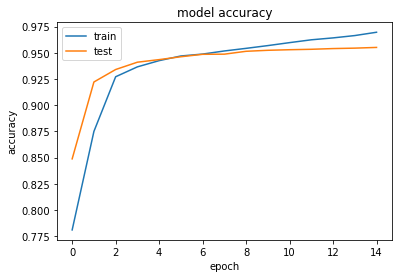

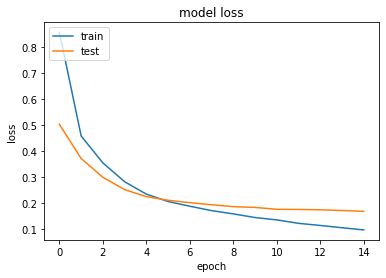

In [24]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()